In [1]:
import mpramnist
from mpramnist.massivestarrdataset import MassiveStarrDataset
from mpramnist import transforms as t
from mpramnist import target_transforms as t_t

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [2]:
class Simple_Net(nn.Module):
    
    def __init__(self, seq_len, block_sizes=[16, 24, 32, 40, 48], kernel_size=3):
        
        super().__init__()
        self.seq_len = seq_len
        out_ch = 64
        nn_blocks = []
      
        for in_bs, out_bs in zip([4] + block_sizes, block_sizes):
            
            block = nn.Sequential(
                nn.Conv1d(in_bs, out_bs, kernel_size=kernel_size, padding=kernel_size // 2), # Padding для сохранения размера
                nn.SiLU(),
                nn.BatchNorm1d(out_bs)
            )
            nn_blocks.append(block)

        final_feature_size = seq_len  # Размер последовательности остаётся неизменным из-за padding
        
        self.conv_net = nn.Sequential(
            *nn_blocks,
            nn.Flatten(),
            nn.Linear(block_sizes[-1] * final_feature_size, out_ch),
            nn.SiLU(),
        )
        
        self.head = nn.Sequential(nn.Linear(out_ch, out_ch),
                                  nn.SiLU(),
                                   nn.BatchNorm1d(out_ch),
                                   nn.Linear(out_ch, 1))
        
        self.output_activation = nn.Sigmoid().cuda()

    def forward(self, x):
        
        out = self.conv_net(x)
        out = self.head(out)
        
        #return self.output_activation(out)
        return out

In [3]:
import pytorch_lightning as L
from pytorch_lightning import loggers as pl_loggers
from torch.cuda.amp import autocast
from torch.nn import functional as F
class Seq1Model(L.LightningModule):
    
    def __init__(self, seq_len, lr=3e-4):
        super().__init__()
        self.model = Simple_Net(seq_len)
        self.loss = torch.nn.BCEWithLogitsLoss().cuda()
        self.lr = lr
        self.val_loss = []
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        X, y = batch
        y_hat = self.model(X).squeeze().cuda()
        y = y.cuda()
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True,  on_step=True, on_epoch=True, logger = True)
        
        lr = self.optimizers().param_groups[0]['lr']  # Get current learning rate
        self.log('learning_rate', lr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x).squeeze().cuda()
        y = y.cuda()
        loss = self.loss(y_hat, y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_loss.append(loss)
        
    def on_validation_epoch_end(self):

        val_loss = torch.stack(self.val_loss, dim = 0).mean()
        
        res_str = '|' + ' {}: {:.5f} |'.format("current_epoch", self.current_epoch) 
        res_str += ' {}: {:.5f} |'.format("val_loss", val_loss)
        border = '-'*len(res_str)
        print("\n".join(['',border, res_str, border,'']))
        self.val_loss.clear()
        return None
        
    def test_step(self, batch, _):
        x, y = batch
        y_hat = self.model(x).squeeze()
        loss = self.loss(y_hat, y)
        
        self.log('test_loss', 
                 loss, 
                 prog_bar=True, 
                 on_step=False,
                 on_epoch=True)
        
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        if isinstance(batch, tuple) or isinstance(batch, list):
            x, _ = batch
        else:
            x = batch
        return self(x)

    def configure_optimizers(self):
        
        self.optimizer = torch.optim.AdamW(self.parameters(),
                                               lr=self.lr,
                                               weight_decay = 0.01)
        
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, # type: ignore
                                                        max_lr=self.lr,
                                                        three_phase=False, 
                                                        total_steps=self.trainer.estimated_stepping_batches, # type: ignore
                                                        pct_start=0.3,
                                                        cycle_momentum =False)
        lr_scheduler_config = {
                    "scheduler": lr_scheduler,
                    "interval": "step",
                    "frequency": 1,
                    "name": "cycle_lr"
            }
            
        return [self.optimizer], [lr_scheduler_config]

In [4]:
import sklearn
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
def plotting_PR_AUC(seq_model, loader):
    act = nn.Sigmoid()
    #get predicted values
    y_preds = trainer.predict(seq_model, dataloaders=loader)
    y_preds = torch.concat(y_preds).cpu().numpy()
    y_preds = torch.tensor(y_preds).squeeze()
    #get target values
    targets = []
    for i, batch in enumerate(loader):
        x, y = batch
        targets.append(y)
    targets = torch.tensor(torch.concat(targets).cpu().numpy())
    y_preds = act(y_preds)
    
    threshold = 0.5  # Пример порога
    y_true = targets.numpy()
    y_pred = (y_preds.numpy() >= threshold).astype(int)
    y_scores = y_preds.numpy()
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    print(f"Precision (при пороге {threshold}): {precision:.2f}")
    print(f"Recall (при пороге {threshold}): {recall:.2f}")
    
    # 2. Построение PR-кривой
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, y_scores)
    
    # Вычисление PR-AUC
    pr_auc = auc(recall_vals, precision_vals)
    
    print(f"PR-AUC: {pr_auc:.2f}")
    
    # 3. Построение графика PR-кривой
    plt.figure(figsize=(4,3))
    plt.plot(recall_vals, precision_vals, label=f'PR Curve (AUC = {pr_auc:.2f})', linewidth=2)
    plt.xlabel('Recall', fontsize=6)
    plt.ylabel('Precision', fontsize=6)
    plt.title('Precision-Recall Curve', fontsize=7)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Tasks

In [5]:
tasks = ["RandomEnhancer",           # 0
          "GenomicPromoter",         # 1
          "CapturePromoter",         # 2
          
          "GenomicEnhancer",         # 3
          "AtacSeq",                 # 4
          
          "differentialExpression",  # 5

          "Binary"                   # 6
         ]

# Random Enhancer

In [5]:
BATCH_SIZE = 1024
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])
task = "RandomEnhancer"
train_dataset = MassiveStarrDataset(task = task, split = "train",transform = train_transform)

val_dataset = MassiveStarrDataset(task = task, split = "val",transform = val_test_transform) 

test_dataset = MassiveStarrDataset(task = task, split = "test", transform = val_test_transform)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [6]:
seq_model = Seq1Model(seq_len=len(train_dataset[0][0][0]), lr = 0.01)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=5,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = False,
    #callbacks=[TQDMProgressBar(refresh_rate=55)]
    #logger = logger
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-01-17 18:41:33.485035: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 18:41:33.498908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one 


----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.69741 |
----------------------------------------------


----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.67923 |
----------------------------------------------


----------------------------------------------
| current_epoch: 1.00000 | val_loss: 0.67754 |
----------------------------------------------


----------------------------------------------
| current_epoch: 2.00000 | val_loss: 0.67562 |
----------------------------------------------


----------------------------------------------
| current_epoch: 3.00000 | val_loss: 0.67354 |
----------------------------------------------



`Trainer.fit` stopped: `max_epochs=5` reached.



----------------------------------------------
| current_epoch: 4.00000 | val_loss: 0.67350 |
----------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.58
Recall (при пороге 0.5): 0.40
PR-AUC: 0.61


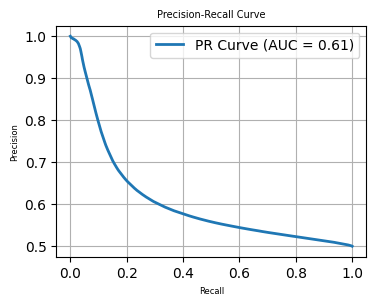

In [7]:
plotting_PR_AUC(seq_model, test_loader)

# Genomic promoter

In [6]:
class Simple_Net(nn.Module):
    
    def __init__(self, seq_len, block_sizes=[32, 64, 128, 256], kernel_size=5):
        
        super().__init__()
        self.seq_len = seq_len
        out_ch = 64
        nn_blocks = []
      
        for in_bs, out_bs in zip([4] + block_sizes, block_sizes):
            
            block = nn.Sequential(
                nn.Conv1d(in_bs, out_bs, kernel_size=kernel_size, padding=kernel_size // 2), # Padding для сохранения размера
                nn.SiLU(),
                nn.BatchNorm1d(out_bs)
            )
            nn_blocks.append(block)

        final_feature_size = seq_len  # Размер последовательности остаётся неизменным из-за padding
        
        self.conv_net = nn.Sequential(
            *nn_blocks,
            nn.Flatten(),
            nn.Linear(block_sizes[-1] * final_feature_size, out_ch),
            nn.SiLU(),
        )
        
        self.head = nn.Sequential(nn.Linear(out_ch, out_ch),
                                  nn.SiLU(),
                                   nn.BatchNorm1d(out_ch),
                                   nn.Linear(out_ch, 1))
        
        self.output_activation = nn.Sigmoid().cuda()

    def forward(self, x):
        
        out = self.conv_net(x)
        out = self.head(out)
        
        #return self.output_activation(out)
        return out

In [6]:
BATCH_SIZE = 128
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])
task = "genomicpromoter"
train_dataset = MassiveStarrDataset(task = task, split = "train",transform = train_transform)

val_dataset = MassiveStarrDataset(task = task, split = "val",transform = val_test_transform) 

test_dataset = MassiveStarrDataset(task = task, split = "test", transform = val_test_transform)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [7]:
seq_model = Seq1Model(seq_len=len(train_dataset[0][0][0]), lr = 0.01)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=5,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = False,
    #callbacks=[TQDMProgressBar(refresh_rate=55)]
    #logger = logger
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-01-20 17:07:06.892143: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-20 17:07:06.907191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one 


----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.68386 |
----------------------------------------------


----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.24961 |
----------------------------------------------


----------------------------------------------
| current_epoch: 1.00000 | val_loss: 0.22718 |
----------------------------------------------


----------------------------------------------
| current_epoch: 2.00000 | val_loss: 0.22288 |
----------------------------------------------


----------------------------------------------
| current_epoch: 3.00000 | val_loss: 0.23618 |
----------------------------------------------



`Trainer.fit` stopped: `max_epochs=5` reached.



----------------------------------------------
| current_epoch: 4.00000 | val_loss: 0.29257 |
----------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.50
Recall (при пороге 0.5): 0.07
PR-AUC: 0.50


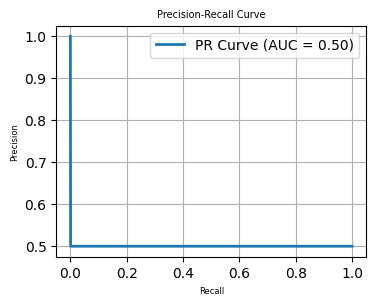

In [8]:
plotting_PR_AUC(seq_model, test_loader)

In [18]:
act = nn.Sigmoid()
    #get predicted values
y_preds = trainer.predict(seq_model, dataloaders=test_loader)
y_preds = torch.concat(y_preds).cpu().numpy()
y_preds = torch.tensor(y_preds).squeeze()
    #get target values
targets = []
for i, batch in enumerate(test_loader):
    x, y = batch
    targets.append(y)
targets = torch.tensor(torch.concat(targets).cpu().numpy())
y_preds = act(y_preds)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


# Promoter capture

In [9]:
BATCH_SIZE = 512
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])
task = "CapturePromoter"
train_dataset = MassiveStarrDataset(task = task, split = "train",transform = train_transform)

val_dataset = MassiveStarrDataset(task = task, split = "val",transform = val_test_transform) 

test_dataset = MassiveStarrDataset(task = task, split = "test", transform = val_test_transform)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [51]:
seq_model = Seq1Model(seq_len=len(train_dataset[0][0][0]), lr = 0.01)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=5,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = False,
    #callbacks=[TQDMProgressBar(refresh_rate=55)]
    #logger = logger
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | Simple_Net        | 386 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
386 K     Trainable params
0         Non-trainable params
386 K     Total params
1.547     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode



----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.64134 |
----------------------------------------------


----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.41483 |
----------------------------------------------


----------------------------------------------
| current_epoch: 1.00000 | val_loss: 0.37456 |
----------------------------------------------


----------------------------------------------
| current_epoch: 2.00000 | val_loss: 0.34507 |
----------------------------------------------


----------------------------------------------
| current_epoch: 3.00000 | val_loss: 0.35789 |
----------------------------------------------



`Trainer.fit` stopped: `max_epochs=5` reached.



----------------------------------------------
| current_epoch: 4.00000 | val_loss: 0.43283 |
----------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.85
Recall (при пороге 0.5): 0.83
PR-AUC: 0.92


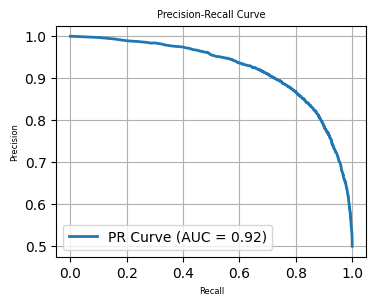

In [52]:
plotting_PR_AUC(seq_model, test_loader)

# Genome enhancer

In [10]:
BATCH_SIZE = 1024
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])
task = "GenomicEnhancer"
train_dataset = MassiveStarrDataset(task = task, split = "train",transform = train_transform)

val_dataset = MassiveStarrDataset(task = task, split = "val",transform = val_test_transform) 

test_dataset = MassiveStarrDataset(task = task, split = "test", transform = val_test_transform)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [6]:
seq_model = Seq1Model(seq_len=len(train_dataset[0][0][0]), lr = 0.01)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=5,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = False,
    #callbacks=[TQDMProgressBar(refresh_rate=55)]
    #logger = logger
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-12-22 21:25:48.873007: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-22 21:25:48.888167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one 


----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.62637 |
----------------------------------------------


----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.56372 |
----------------------------------------------


----------------------------------------------
| current_epoch: 1.00000 | val_loss: 0.55484 |
----------------------------------------------


----------------------------------------------
| current_epoch: 2.00000 | val_loss: 0.53585 |
----------------------------------------------


----------------------------------------------
| current_epoch: 3.00000 | val_loss: 0.52830 |
----------------------------------------------



`Trainer.fit` stopped: `max_epochs=5` reached.



----------------------------------------------
| current_epoch: 4.00000 | val_loss: 0.54086 |
----------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.81
Recall (при пороге 0.5): 0.63
PR-AUC: 0.84


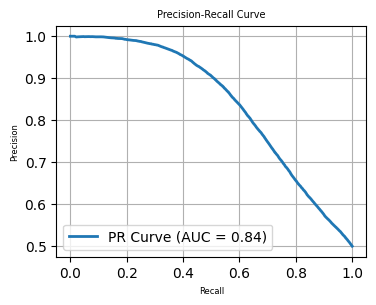

In [7]:
plotting_PR_AUC(seq_model, test_loader)

# ATACseq

In [11]:
BATCH_SIZE = 2048
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])
task = "atacseq"
train_dataset = MassiveStarrDataset(task = task, split = "train",transform = train_transform)

val_dataset = MassiveStarrDataset(task = task, split = "val",transform = val_test_transform) 

test_dataset = MassiveStarrDataset(task = task, split = "test", transform = val_test_transform)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [37]:
seq_model = Seq1Model(seq_len=len(train_dataset[0][0][0]), lr = 0.01)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=5,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = False,
    #callbacks=[TQDMProgressBar(refresh_rate=55)]
    #logger = logger
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | Simple_Net        | 540 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
540 K     Trainable params
0         Non-trainable params
540 K     Total params
2.162     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode



----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.72036 |
----------------------------------------------


----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.39401 |
----------------------------------------------


----------------------------------------------
| current_epoch: 1.00000 | val_loss: 0.38693 |
----------------------------------------------


----------------------------------------------
| current_epoch: 2.00000 | val_loss: 0.37577 |
----------------------------------------------


----------------------------------------------
| current_epoch: 3.00000 | val_loss: 0.37593 |
----------------------------------------------



`Trainer.fit` stopped: `max_epochs=5` reached.



----------------------------------------------
| current_epoch: 4.00000 | val_loss: 0.38308 |
----------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.86
Recall (при пороге 0.5): 0.73
PR-AUC: 0.90


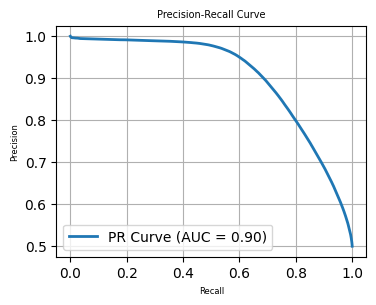

In [38]:
plotting_PR_AUC(seq_model, test_loader)

# Differential Expression task

In [8]:
BATCH_SIZE = 32
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])
task = tasks[5]
length = 150
train_dataset = MassiveStarrDataset(task = task, split = "train", length = length, transform = train_transform)

val_dataset = MassiveStarrDataset(task = task, split = "val", length = length, transform = val_test_transform) 

test_dataset = MassiveStarrDataset(task = task, split = "test", length = length, transform = val_test_transform)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [9]:
print(train_dataset)
print("="*20)
print(val_dataset)
print("="*20)
print(test_dataset)

Dataset MassiveStarrDataset of size 8230 (MpraDaraset)
    Number of datapoints: 8230
    Default split folds: {}
    Used split fold: ['chr1', 'chr3', 'chr5', 'chr7', 'chr9', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
    Scalar features: {}
    Vector features: {}
    Cell types: None
    Сell type used: None
    Target columns that can be used: {}
    Number of channels: 4
    Sequence size: 150
    Number of samples: {}
    Description: MassiveStarrDataset is based on 
Dataset MassiveStarrDataset of size 1467 (MpraDaraset)
    Number of datapoints: 1467
    Default split folds: {}
    Used split fold: ['chr4', 'chr6', 'chr8']
    Scalar features: {}
    Vector features: {}
    Cell types: None
    Сell type used: None
    Target columns that can be used: {}
    Number of channels: 4
    Sequence size: 150
    Number of samples: {}
    Description: MassiveStarrDataset is based on 
Dataset MassiveStarrDataset of size 2041 (MpraDa

In [15]:
import pytorch_lightning as L
from torch.nn import functional as F
def pearson_correlation(x, y):
    vx = x - torch.mean(x, dim=0)
    vy = y - torch.mean(y, dim=0)
    pearsons = torch.sum(vx * vy, dim=0) / (torch.sqrt(torch.sum(vx ** 2, dim=0)) * torch.sqrt(torch.sum(vy ** 2, dim=0)) + 1e-10)
    return torch.mean(pearsons)
class SeqModel(L.LightningModule):
    
    def __init__(self, seq_len, lr=3e-4):
        super().__init__()
        self.model = Simple_Net(seq_len)
        self.loss = torch.nn.BCEWithLogitsLoss().cuda()
        self.lr = lr
        self.val_loss = []
        self.val_pears = []
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        X, y = batch
        y_hat = self.model(X).squeeze().cuda()
        y = y.cuda()
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True,  on_step=True, on_epoch=True, logger = True)
        
        lr = self.optimizers().param_groups[0]['lr']  # Get current learning rate
        self.log('learning_rate', lr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x).squeeze().cuda()
        y = y.cuda()
        loss = self.loss(y_hat, y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_loss.append(loss)

        corr = pearson_correlation(y_hat, y)
        self.val_pears.append(corr)
        self.log("val_pearson", corr, on_epoch=True, prog_bar=True, on_step = False)
        
    def on_validation_epoch_end(self):

        val_loss = torch.stack(self.val_loss, dim = 0).mean()
        val_pears = torch.stack(self.val_pears, dim = 0).mean()
        
        res_str = '|' + ' {}: {:.5f} |'.format("current_epoch", self.current_epoch) 
        res_str += ' {}: {:.5f} |'.format("val_loss", val_loss)
        res_str += ' {}: {:.5f} |'.format("val_pearson", val_pears)
        border = '-'*len(res_str)
        print("\n".join(['',border, res_str, border,'']))
        self.val_loss.clear()
        return None
        
    def test_step(self, batch, _):
        x, y = batch
        y_hat = self.model(x).squeeze()
        loss = self.loss(y_hat, y)
        
        self.log('test_loss', 
                 loss, 
                 prog_bar=True, 
                 on_step=False,
                 on_epoch=True)
        corr = pearson_correlation(y_hat, y)
        self.log("test_pearson", 
                 corr ,
                 on_epoch=True,
                 prog_bar=True,
                 on_step=False,)
        
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        if isinstance(batch, tuple) or isinstance(batch, list):
            x, _ = batch
        else:
            x = batch
        return self(x)

    def configure_optimizers(self):
        
        self.optimizer = torch.optim.AdamW(self.parameters(),
                                               lr=self.lr,
                                               weight_decay = 0.01)
        
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, # type: ignore
                                                        max_lr=self.lr,
                                                        three_phase=False, 
                                                        total_steps=self.trainer.estimated_stepping_batches, # type: ignore
                                                        pct_start=0.3,
                                                        cycle_momentum =False)
        lr_scheduler_config = {
                    "scheduler": lr_scheduler,
                    "interval": "step",
                    "frequency": 1,
                    "name": "cycle_lr"
            }
            
        return [self.optimizer], [lr_scheduler_config]

In [16]:
seq_model = SeqModel(seq_len=len(train_dataset[0][0][0]), lr = 0.01)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=5,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = False,
    #callbacks=[TQDMProgressBar(refresh_rate=55)]
    #logger = logger
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | Simple_Net        | 478 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
478 K     Trainable params
0         Non-trainable params
478 K     Total params
1.916     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode



---------------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.71369 | val_pearson: 0.16018 |
---------------------------------------------------------------------


---------------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.40466 | val_pearson: 0.00750 |
---------------------------------------------------------------------


---------------------------------------------------------------------
| current_epoch: 1.00000 | val_loss: 0.41049 | val_pearson: 0.01369 |
---------------------------------------------------------------------


---------------------------------------------------------------------
| current_epoch: 2.00000 | val_loss: 0.43264 | val_pearson: 0.03192 |
---------------------------------------------------------------------


---------------------------------------------------------------------
| current_epoch: 3.00000 | val_loss: 0.31690 | val_pearson: 0.04202 |
-----------

`Trainer.fit` stopped: `max_epochs=5` reached.



---------------------------------------------------------------------
| current_epoch: 4.00000 | val_loss: 0.36871 | val_pearson: 0.04472 |
---------------------------------------------------------------------



# Binary task

In [6]:
BATCH_SIZE = 1024
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])
task = tasks[6]
prom_or_enh = "enhancer"
train_dataset = MassiveStarrDataset(task = task, prom_or_enh = "enhancer_permutated", split = "train",transform = train_transform)

val_dataset = MassiveStarrDataset(task = task, prom_or_enh = prom_or_enh, split = "val",transform = val_test_transform) 

test_dataset = MassiveStarrDataset(task = task, prom_or_enh = prom_or_enh, split = "test", transform = val_test_transform)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [7]:
print(train_dataset)
print("="*20)
print(val_dataset)
print("="*20)
print(test_dataset)

Dataset MassiveStarrDataset of size 2991302 (MpraDaraset)
    Number of datapoints: 2991302
    Default split folds: {}
    Used split fold: train
    Scalar features: {}
    Vector features: {}
    Cell types: None
    Сell type used: None
    Target columns that can be used: {}
    Number of channels: 4
    Sequence size: 150
    Number of samples: {}
    Description: MassiveStarrDataset is based on 
Dataset MassiveStarrDataset of size 748828 (MpraDaraset)
    Number of datapoints: 748828
    Default split folds: {}
    Used split fold: val
    Scalar features: {}
    Vector features: {}
    Cell types: None
    Сell type used: None
    Target columns that can be used: {}
    Number of channels: 4
    Sequence size: 150
    Number of samples: {}
    Description: MassiveStarrDataset is based on 
Dataset MassiveStarrDataset of size 1252044 (MpraDaraset)
    Number of datapoints: 1252044
    Default split folds: {}
    Used split fold: test
    Scalar features: {}
    Vector features: {

In [21]:
seq_model = Seq1Model(seq_len=len(train_dataset[0][0][0]), lr = 0.01)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=5,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = False,
    #callbacks=[TQDMProgressBar(refresh_rate=55)]
    #logger = logger
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-01-20 14:39:44.572595: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-20 14:39:44.586179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one 


----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.75484 |
----------------------------------------------


----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.66753 |
----------------------------------------------


----------------------------------------------
| current_epoch: 1.00000 | val_loss: 0.66960 |
----------------------------------------------


----------------------------------------------
| current_epoch: 2.00000 | val_loss: 0.66354 |
----------------------------------------------


----------------------------------------------
| current_epoch: 3.00000 | val_loss: 0.66089 |
----------------------------------------------



`Trainer.fit` stopped: `max_epochs=5` reached.



----------------------------------------------
| current_epoch: 4.00000 | val_loss: 0.66069 |
----------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.59
Recall (при пороге 0.5): 0.61
PR-AUC: 0.63


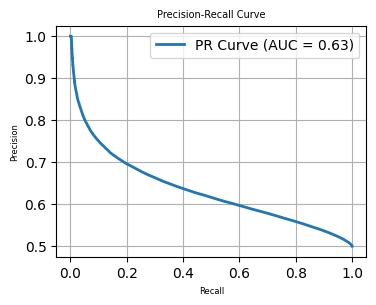

In [22]:
plotting_PR_AUC(seq_model, test_loader)